In [16]:
#!pip install numpy pandas tqdm matplotlib sentence-transformers scikit-learn tensorflow

In [17]:
# Importing the required libraries

import sqlite3
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm, trange
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, AdamW
from tensorflow.keras.layers import Dense, ReLU, BatchNormalization, Input, Dropout, LeakyReLU
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [18]:
# Loading the training data

df_train = pd.read_csv("train.csv")
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Obtaining the embeddings for the text data

model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True).cuda()

text_embeddings = []
for text in tqdm(df_train["text"].tolist(), total=len(df_train)):
    text_embeddings.append(model.encode(text, convert_to_tensor=False))


df_train["text_embeddings"] = text_embeddings
print(df_train.info())

# Connect to the SQLite database

conn = sqlite3.connect("df_train_stella.db")
cursor = conn.cursor()

# Create the table with the specified columns

cursor.execute("""
    CREATE TABLE IF NOT EXISTS embeddings (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        keyword TEXT,
        location TEXT,
        text TEXT,
        target INTEGER,
        text_embeddings BLOB
    )
""")

conn.commit()

# Insert data into the table

for idx, (keyword, location, text, target, text_emb) in enumerate(zip(df_train["keyword"], df_train["location"], df_train["text"], df_train["target"], text_embeddings)):
    text_emb_np = text_emb
    cursor.execute("""
        INSERT INTO embeddings (keyword, location, text, target, text_embeddings)
        VALUES (?, ?, ?, ?, ?)
    """, (keyword, location, text, target, text_emb_np.tobytes()))

conn.commit()
conn.close()

In [20]:
# Load the embeddings from the vector database

def load_embeddings_train(db_path):
    conn = sqlite3.connect(db_path)
    
    query = "SELECT * FROM embeddings"
    result = conn.execute(query).fetchall()
    
    columns = ["id", "keyword", "location", "text", "target", "text_embeddings"]
    df = pd.DataFrame(result, columns=columns)
    
    df["text_embeddings"] = df["text_embeddings"].apply(lambda x: np.frombuffer(x, dtype=np.float32))
    
    conn.close()
    
    return df

training_df = load_embeddings_train("df_train_stella.db")
training_df.head()

,id,keyword,location,text,target,text_embeddings
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1,"[0.2852046, 0.5886476, -1.3216673, 0.29986036,..."
1,2,None,None,Forest fire near La Ronge Sask. Canada,1,"[-0.05745545, 0.59229136, -1.5204103, 0.458869..."
2,3,None,None,All residents asked to 'shelter in place' are ...,1,"[0.39219254, 0.1601345, -1.9410663, 1.2441117,..."
3,4,None,None,"13,000 people receive #wildfires evacuation or...",1,"[0.83750695, -0.039204597, -1.1120598, 0.79314..."
4,5,None,None,Just got sent this photo from Ruby #Alaska as ...,1,"[0.40162104, 0.10419981, -1.7102512, 1.103035,..."


In [21]:
# Drop the duplicates for training

training_df = training_df.drop_duplicates(subset="text")
print(len(training_df["text_embeddings"][0]))

1024


In [22]:
# Load Data 

text_embeddings = np.array(training_df["text_embeddings"].tolist())
targets = np.array(training_df["target"].tolist())

# Train-Test-Validation Split

X_train, X_temp, y_train, y_temp = train_test_split(text_embeddings, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build the Model

model = Sequential([
    Input(shape=(text_embeddings.shape[1],)),
    Dense(528),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(8),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

# Compile the Model

optimizer = Adagrad(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=BinaryCrossentropy(from_logits=True),  
              metrics=[BinaryAccuracy()])

# Learning rate scheduler

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Train the Model

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), callbacks=[lr_scheduler], batch_size=512)

# Evaluate the Model

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - binary_accuracy: 0.5168 - loss: 0.9374 - val_binary_accuracy: 0.5667 - val_loss: 0.6790 - learning_rate: 0.0010
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.5392 - loss: 0.8852 - val_binary_accuracy: 0.5667 - val_loss: 0.6710 - learning_rate: 0.0010
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.5550 - loss: 0.8493 - val_binary_accuracy: 0.5667 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.5876 - loss: 0.7802 - val_binary_accuracy: 0.5760 - val_loss: 0.6500 - learning_rate: 0.0010
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.5947 - loss: 0.7767 - val_binary_accuracy: 0.5893 - val_loss: 0.6383 - learning_rate: 0.0010
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.6201 - loss: 0.7519 - val_binary_accuracy: 0.6213 - val_loss: 0.6272 - learning_rate: 0.0010
Epoc

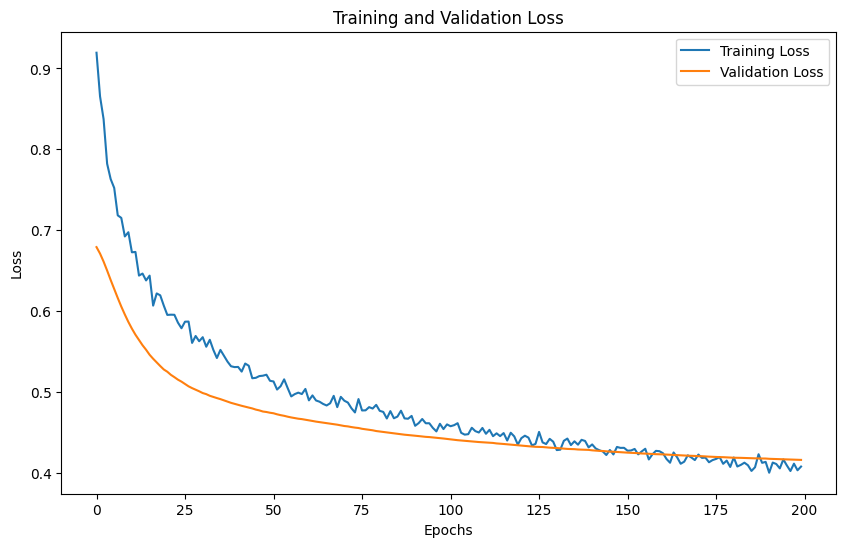

In [23]:
# Plot of the Losses

plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

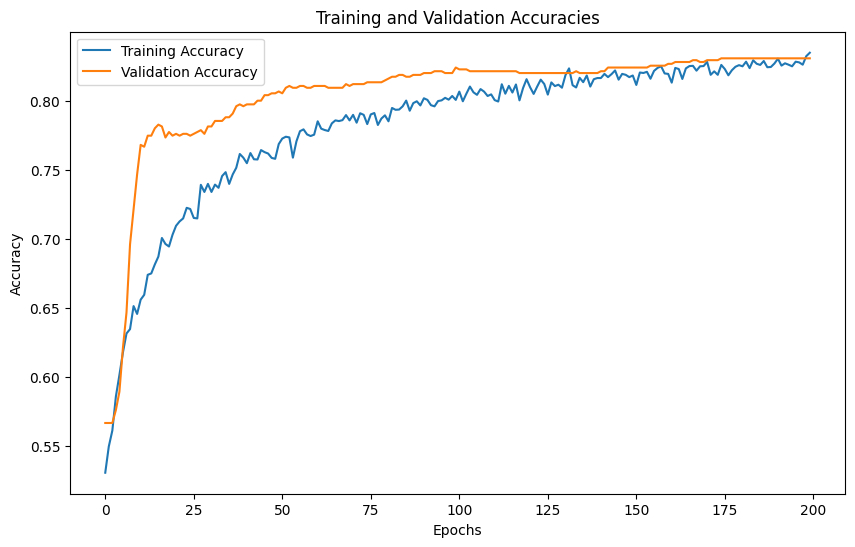

In [24]:
# Plot of the Accuracies

plt.figure(figsize=(10, 6))
plt.plot(history.history["binary_accuracy"], label="Training Accuracy")
plt.plot(history.history["val_binary_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracies")
plt.legend()
plt.show()

### Testing

In [25]:
# Loading the testing data

df_test = pd.read_csv("test.csv")
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Obtaining the embeddings for the text data

model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True).cuda()

text_embeddings = []
for text in tqdm(df_test["text"].tolist(), total=len(df_test)):
    text_embeddings.append(model.encode(text, convert_to_tensor=False))

df_test["text_embeddings"] = text_embeddings
print(df_test.info())

# Connect to the SQLite database

conn = sqlite3.connect("df_test_stella.db")
cursor = conn.cursor()

# Create the table with the specified columns

cursor.execute("""
    CREATE TABLE IF NOT EXISTS embeddings (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        keyword TEXT,
        location TEXT,
        text TEXT,
        text_embeddings BLOB
    )
""")

conn.commit()

# Insert data into the table

for idx, (keyword, location, text, text_emb) in enumerate(zip(df_test["keyword"], df_test["location"], df_test["text"], text_embeddings)):
    text_emb_np = text_emb
    cursor.execute("""
        INSERT INTO embeddings (keyword, location, text, text_embeddings)
        VALUES (?, ?, ?, ?)
    """, (keyword, location, text, text_emb_np.tobytes()))

conn.commit()
conn.close()

In [26]:
# Load the embeddings from the vector database

def load_embeddings_test(db_path):
    conn = sqlite3.connect(db_path)
    
    query = "SELECT * FROM embeddings"
    result = conn.execute(query).fetchall()
    
    columns = ["id", "keyword", "location", "text", "text_embeddings"]
    df = pd.DataFrame(result, columns=columns)
    
    df["text_embeddings"] = df["text_embeddings"].apply(lambda x: np.frombuffer(x, dtype=np.float32))
    
    conn.close()
    
    return df

testing_df = load_embeddings_test("df_test_stella.db")
testing_df.head()

,id,keyword,location,text,text_embeddings
0,1,None,None,Just happened a terrible car crash,"[-0.07637273, -0.07767132, -1.829082, 0.292002..."
1,2,None,None,"Heard about #earthquake is different cities, s...","[0.7331115, -0.16246109, -1.8786962, 0.5562855..."
2,3,None,None,"there is a forest fire at spot pond, geese are...","[0.31106567, 0.40532568, -1.7875249, 0.0526289..."
3,4,None,None,Apocalypse lighting. #Spokane #wildfires,"[0.60017174, 0.12376606, -2.1918435, 0.2003688..."
4,5,None,None,Typhoon Soudelor kills 28 in China and Taiwan,"[0.33720857, -0.09090513, -1.1346045, -0.12233..."


In [27]:
# Format the data for prediction

embeddings = np.array(testing_df["text_embeddings"].tolist())
predictions = model.predict(embeddings)
binary_predictions = (predictions >= 0.5).astype(int)
predictions_df = pd.DataFrame()
predictions_df["id"] = df_test["id"]
predictions_df = predictions_df.merge(df_test[["id"]], on="id", how="left")
predictions_df["target"] = binary_predictions
predictions_df.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [28]:
# Count the number of predictions that are 0 and 1

count_0 = np.count_nonzero(predictions_df["target"] == 0)
count_1 = np.count_nonzero(predictions_df["target"] == 1)

print("Number of predictions that are 0:", count_0)
print("Number of predictions that are 1:", count_1)

Number of predictions that are 0: 2063
Number of predictions that are 1: 1200


In [29]:
# Export the predictions to a CSV file

predictions_df.to_csv("predictions_submissions.csv", index=False)